In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import access_spectrum as acs
from run_empca import *
import polyfit as pf
silent=False
# Remember, the windows are the INVERSE of the absorption features

/usr/lib/python2.7/site-packages/setuptools-18.7.1-py2.7.egg/pkg_resources/__init__.py:1266: UserWarning: /home/price-jones/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
/home/price-jones/Code/apogee/apogee/spec/window.py:88: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True-numpy.isnan(win))).astype('int')


Populating the interactive namespace from numpy and matplotlib
/usr/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)



In [2]:
windowinfo = 'pickles/windowinfo.pkl'
elemwindows,window_all,window_peak,windowPeaks,windowPixels,tophats = acs.pklread(windowinfo)

In [3]:
specs = acs.pklread('red_clump/pickles/spectra_FE_H_u-0.4_d-0.5.pkl')[0]

In [4]:
errs = acs.pklread('red_clump/pickles/errs_FE_H_u-0.4_d-0.5.pkl')

In [5]:
SNR = specs/errs

In [6]:
vec = np.tile(elemwindows['C']+elemwindows['Al'],(specs.shape[0],1))

In [7]:
falsespecs = np.ma.masked_array(vec,specs.mask)

In [8]:
noise = falsespecs/SNR

In [9]:
drawn_noise = noise*np.random.randn(noise.shape[0],noise.shape[1])

In [10]:
falsespecs += drawn_noise

In [11]:
falsespecs.mask[np.where(noise<1e-10)] = True
noise.mask[np.where(noise<1e-10)] = True

In [14]:
def vec_weight(elem,vec):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    return np.ma.sum(nw*vec)
    
def arr_weight(elem,arr):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    nws = np.tile(nw,(arr.shape[0],1))
    return np.ma.sum(nws*arr,axis=1)
    
def test_run(specs,noise,deltR2=2e-3,nvecs=5,mad=True,maxvec=5):
    m1,m2,w1,w2 = pix_empca(None,specs.T,noise,'test.pkl',nvecs=nvecs,deltR2=2e-3,gen=True,usemad=mad)
    R2_1 = R2(m1) #must be here (and not below resize) to avoid error
    R2_2 = R2(m2)
    resize_pix_eigvecs(specs.T,m1,nstars=5)
    resize_pix_eigvecs(specs.T,m2,nstars=5)
    m1elem = np.zeros((nvecs,len(elems)))
    m2elem = np.zeros((nvecs,len(elems)))
    specs_weight = np.ma.masked_array(np.zeros((len(elems),specs.shape[0])))
    noise_weight = np.ma.masked_array(np.zeros((len(elems),specs.shape[0])))
    for ind in range(len(elems)):
        specs_weight[ind] = arr_weight(elems[ind],specs)
        noise_weight[ind] = arr_weight(elems[ind],noise)
        for vec in range(nvecs):
            m1elem[vec][ind] = vec_weight(elems[ind],m1.eigvec[vec])
            m2elem[vec][ind] = vec_weight(elems[ind],m2.eigvec[vec])
    m3,m4,w3,w4 = elem_empca(None,specs_weight,noise_weight,'test2.pkl',nvecs=nvecs,gen=True,deltR2=2e-3,usemad=mad)        
    R2_3 = R2(m3)
    R2_4 = R2(m4)
    for n in range(maxvec):
        plt.figure(figsize=(12,3))
        plt.plot(norm_eigvec(m1elem[n]),marker='o',linewidth = 3,markersize=8)
        plt.plot(norm_eigvec(m2elem[n]),marker='o',linewidth = 3,markersize=8)
        plt.plot(norm_eigvec(m3.eigvec[n]),marker='o',linewidth = 3,markersize=8)
        plt.plot(norm_eigvec(m4.eigvec[n]),marker='o',linewidth = 3,markersize=8)
        plt.axhline(0,linestyle='--',color='k',linewidth=3)
        plt.xticks(range(len(elems)),elems)
        plt.ylabel('Eigenvenctor {0}'.format(n+1))
    plt.figure(figsize=(12,3))
    plt.plot(R2_1,marker='o',linewidth = 3,markersize=8)
    plt.plot(R2_2,marker='o',linewidth = 3,markersize=8)
    plt.plot(R2_3,marker='o',linewidth = 3,markersize=8)
    plt.plot(R2_4,marker='o',linewidth = 3,markersize=8)
    return R2_1,R2_2,R2_3,R2_4

       iter        R2             rchi2
EMPCA  1/25      -0.00000019  26415.62465855
R2: 0.99989304413
       iter        R2             rchi2
EMPCA  1/25              nan 3337382358606423.00000000
EMPCA  2/25              nan 14460465947168.07226562
EMPCA  3/25              nan 5481773751257.46484375
EMPCA  4/25              nan 6783323910472.54785156
EMPCA  5/25              nan   2749.75270824
EMPCA  6/25              nan   2749.16264885
EMPCA  7/25              nan   2442.86764634
EMPCA  8/25              nan   2433.92828494
EMPCA  9/25              nan   2432.07258234
EMPCA 10/25              nan   2429.95568918
EMPCA 11/25              nan   2429.79743781
EMPCA 12/25              nan   2429.78885033
EMPCA 13/25              nan   2429.78766445
EMPCA 14/25              nan   2429.78386902
EMPCA 15/25              nan   2429.78125739
EMPCA 16/25              nan   2429.77791405
EMPCA 17/25              nan   2429.77186294
EMPCA 18/25              nan   2429.75896833
EMPCA 19/25    

(array([ 0.        ,  0.99999326,  0.99999343,  0.99999346,  0.99999352,
         0.99999356]),
 array([ 0.        ,  0.99763952,  0.99771334,  0.99739969,  0.99914448,
         0.99989304]),
 array([ nan,  nan,  nan,  nan,  nan,  nan]),
 array([ nan,  nan,  nan,  nan,  nan,  nan]))

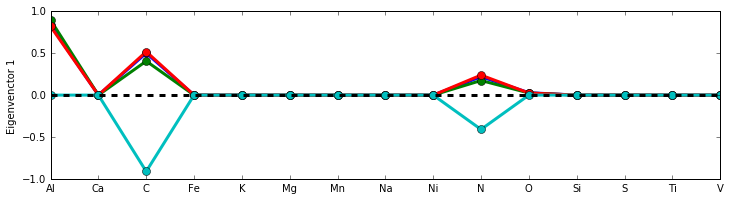

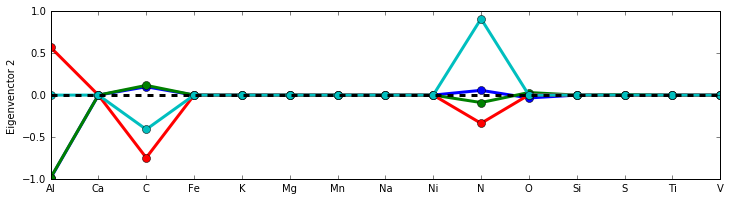

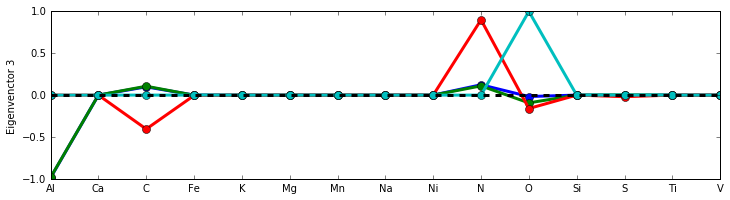

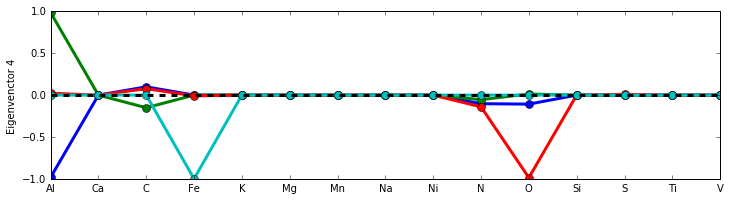

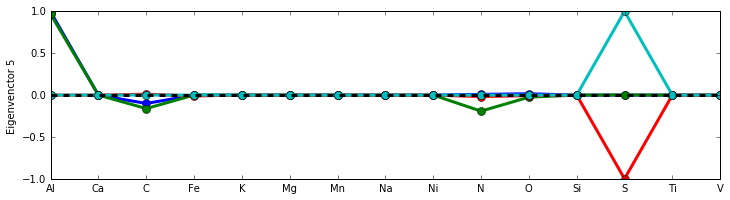

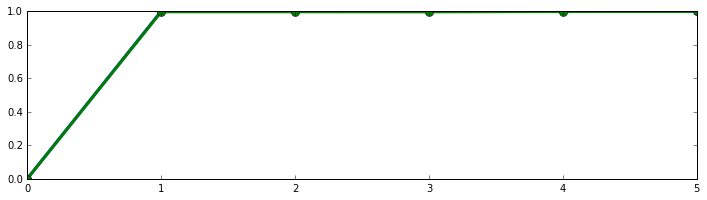

In [15]:
test_run(falsespecs,noise)